## Generate Result Tables
- MCHAD
- CAC
- II
- Center Loss
- G-MCHAD
- G-Center
- G-CAC

In [42]:
import seaborn as sb
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
import pandas as pd
from os.path import join

In [43]:
sb.set()
sb.set_style("whitegrid")
sb.set_context("paper")

In [44]:
# root folder for experiment run
root = "/home/ki/projects/work/mchad/logs/multiruns/22-14:03:02/"

In [45]:
# map test cases
dataset_map = {
    "test_vs_uniformnoise": "Uniform",
    "test_vs_gaussiannoise": "Gaussian",
    "test_vs_tinycrop": "Tiny Crop",
    "test_vs_tinyresize": "Tiny Resize",
    "test_vs_lsuncrop": "LSUN Crop",
    "test_vs_lsunresize": "LSUN Resize",
    "test_vs_textures": "Texture",
}

model_map = {
    "src.models.CAC": "CAC",
    "src.models.Softmax": "Softmax",
    "src.models.MCHAD": "MCHAD",
    "src.models.Center": "Center",
    "src.models.II": "II",
    "src.models.GCAC": "G-CAC",
    "src.models.GCenter": "G-Center",
}


train_dataset_map = {
    "src.datamodules.CIFAR10DataModule": "CIFAR10",
    "src.datamodules.SVHNDataModule": "SVHN",
    "src.datamodules.CIFAR100DataModule": "CIFAR100",
}

In [46]:
def convert(df, key="Distance", task="OOD"):
    """
    Get correct metrics from dataframe
    """
    df.rename(
        inplace=True,
        columns={
            "Accuracy/test": "Accuracy",
            f"{key}/{task}/AUROC/test": "AUROC",
            f"{key}/{task}/AUPR-IN/test": "AUPR-IN",
            f"{key}/{task}/AUPR-OUT/test": "AUPR-OUT",
            f"{key}/{task}/FPR95TPR/test": "FPR95",
        },
    )

    return df

In [47]:
directories = []
directories += [f"./svhn/center/{i}" for i in range(21)]
directories += [f"./svhn/mchad/{i}" for i in range(21)]
directories += [f"./svhn/gmchad/{i}" for i in range(21)]
directories += [f"./svhn/gcenter/{i}" for i in range(21)]
directories += [f"./svhn/gcac/{i}" for i in range(21)]
directories += [f"./svhn/cac/{i}" for i in range(21)]
# directories += [f"./svhn/ii/{i}" for i in range(21)]

directories += [f"./cifar100/mchad/{i}" for i in range(21)]
directories += [f"./cifar100/gmchad/{i}" for i in range(21)]
directories += [f"./cifar100/gcenter/{i}" for i in range(21)]
directories += [f"./cifar100/gcac/{i}" for i in range(21)]
directories += [f"./cifar100/cac/{i}" for i in range(21)]
# directories += [f"./cifar100/ii/{i}" for i in range(21)]
directories += [f"./cifar100/center/{i}" for i in range(21)]


# del directories[directories.index("./cifar100/cac/13")]
directories += [f"./cifar10/mchad/{i}" for i in range(21)]
directories += [f"./cifar10/center/{i}" for i in range(21)]
directories += [f"./cifar10/gmchad/{i}" for i in range(21)]
directories += [f"./cifar10/gcenter/{i}" for i in range(21)]
directories += [f"./cifar10/gcac/{i}" for i in range(21)]
directories += [f"./cifar10/cac/{i}" for i in range(21)]
# directories += [f"./cifar10/ii/{i}" for i in range(21)]

In [48]:


def get_training_set(datamodule):
    target = datamodule["_target_"]
    d = train_dataset_map.get(target)

    if not d:
        if target == "src.datamodules.MultiDatamodule":
            d = train_dataset_map.get(datamodule["module1"]["_target_"])

    if not d:
        print(datamodule)
    else:
        print(d)

    return d


def load(path):
    local_df = []

    df = pd.read_csv(join(path, "results.csv"))
    metrics = pd.read_csv(join(path, "csv/version_0/metrics.csv"))
    config = OmegaConf.load(join(path, "tb/version_0/hparams.yaml"))
    df["Dataset"] = get_training_set(config["datamodule"])
    df["Outliers"] = df["test_case_name"].apply(dataset_map.get)
    model = str(config["model"]["_target_"])

    if model == "src.models.CAC":
        df["Model"] = "CAC"
        df = convert(df, "Distance")
    elif model == "src.models.SoftMax":
        print("EB-OOD")
        df_ebm = df.copy(deep=True)
        df_ebm["Model"] = "EB-OOD"
        df_emb = convert(df_ebm, "EnergyBased")

        local_df.append(df_ebm)

        print("Softmax")
        df["Model"] = "Softmax"
        df = convert(df, "Softmax")

    elif model == "src.models.MCHAD":
        if config["model"]["weight_oe"] == 0.0:
            # print(f"Weight OE: {config['model']['weight_oe']}")
            df["Model"] = "MCHAD"
        else:
            print(f"Weight OE: {config['model']['weight_oe']}")
            df["Model"] = "G-MCHAD"

        df = convert(df)
    elif model == "src.models.Center":
        df["Model"] = "Center"
        df = convert(df, "Distance")
    elif model == "src.models.IIModel":
        df["Model"] = "II"
        df = convert(df)
    elif model == "src.models.GCenter":
        df["Model"] = "G-Center"
        df = convert(df, key="Distance")
    elif model == "src.models.GCAC":
        df["Model"] = "G-CAC"
        df = convert(df, key="Distance")
    else:
        raise Exception(f"UNKNOWN: {model}")

    local_df.append(df)
    return config, pd.concat(local_df), metrics

In [49]:
dfs = []

for d in directories:
    # filter(lambda x: "center" not in x and "cifar100/softmax/" not in x and "mchad-o" not in x, directories):
    path = join(root, d)
    config, df, metrics = load(path)
    try:
        if df is not None:
            print(path)
            print(
                f"{df['Dataset'][0]}/{df['Model'][0]} -> {df['AUROC'].mean()} {len(df)}"
            )
            df = df[
                [
                    "Accuracy",
                    "AUROC",
                    "AUPR-IN",
                    "AUPR-OUT",
                    "FPR95",
                    "Dataset",
                    "Outliers",
                    "Model",
                ]
            ]
            dfs.append(df.copy())
    except Exception as e:
        print("EXCEPTION WHILE LOADING")
        print(type(e), e)
        print(df.columns)

df = pd.concat(dfs)

SVHN
/home/ki/projects/work/mchad/logs/multiruns/22-14:03:02/./svhn/center/0
SVHN/Center -> 0.8512307554483414 8
SVHN
/home/ki/projects/work/mchad/logs/multiruns/22-14:03:02/./svhn/center/1
SVHN/Center -> 0.8575824052095413 8
SVHN
/home/ki/projects/work/mchad/logs/multiruns/22-14:03:02/./svhn/center/2
SVHN/Center -> 0.8578265830874443 8
SVHN
/home/ki/projects/work/mchad/logs/multiruns/22-14:03:02/./svhn/center/3
SVHN/Center -> 0.8618502244353294 8
SVHN
/home/ki/projects/work/mchad/logs/multiruns/22-14:03:02/./svhn/center/4
SVHN/Center -> 0.8589757084846497 8
SVHN
/home/ki/projects/work/mchad/logs/multiruns/22-14:03:02/./svhn/center/5
SVHN/Center -> 0.8579550161957741 8
SVHN
/home/ki/projects/work/mchad/logs/multiruns/22-14:03:02/./svhn/center/6
SVHN/Center -> 0.8559422120451927 8
SVHN
/home/ki/projects/work/mchad/logs/multiruns/22-14:03:02/./svhn/center/7
SVHN/Center -> 0.8584350347518921 8
SVHN
/home/ki/projects/work/mchad/logs/multiruns/22-14:03:02/./svhn/center/8
SVHN/Center -> 0.85

In [50]:
df["AUROC"] = df["AUROC"].apply(lambda x: x * 100)
df["AUPR-IN"] = df["AUPR-IN"].apply(lambda x: x * 100)
df["AUPR-OUT"] = df["AUPR-OUT"].apply(lambda x: x * 100)
df["FPR95"] = df["FPR95"].apply(lambda x: x * 100)
df["Accuracy"] = df["Accuracy"].apply(lambda x: x * 100)

In [51]:
# , "Tiny Crop", "LSUN Crop"
# df = df[df["Outliers"].isin(["Texture", "Tiny Resize", "LSUN Resize", "Uniform", "Gaussian"])]
df = df.set_index(["Dataset", "Outliers", "Model"]).dropna()


In [52]:
from itertools import product
datasets = ["SVHN", "CIFAR10", "CIFAR100"]
# models = ["CAC", "II", "Center", "Softmax", "EB-OOD", "MCHAD", "G-MCHAD"]
models = ["MCHAD", "II", "CAC", "Center", "G-MCHAD", "G-Center", "G-CAC"]

t =  df.reset_index().groupby(by=["Dataset", "Model"]).agg(
        {
            "Accuracy": ["mean", "sem"],
            "AUROC": ["mean", "sem"],
            "AUPR-IN": ["mean", "sem"],
            "AUPR-OUT": ["mean", "sem"],
            "FPR95": ["mean", "sem"],
        }
    ).reindex(list(product(datasets, models)))

s = t.to_latex(
        float_format="%.2f",
        multirow=True,
        escape=False,
        label="tab:results",
        # bold_rows="True",
    )

repl = {
    "mean": "Mean",
    "sem": "$\\pm \sigma_{\\bar{x}}$",
    " MCHAD": " \\textbf{MCHAD (ours)}",
    "G-MCHAD": "\\textbf{G-MCHAD (ours)}",
    "G-Center": "\\textbf{G-Center (ours)}",
    "G-CAC": "\\textbf{G-CAC (ours)}",
}

for k, v in repl.items():
    s = s.replace(k, v)

print(s)

\begin{table}
\centering
\label{tab:results}
\begin{tabular}{llrrrrrrrrrr}
\toprule
         &       & \multicolumn{2}{l}{Accuracy} & \multicolumn{2}{l}{AUROC} & \multicolumn{2}{l}{AUPR-IN} & \multicolumn{2}{l}{AUPR-OUT} & \multicolumn{2}{l}{FPR95} \\
         &       &     Mean &  $\pm \sigma_{\bar{x}}$ &  Mean &  $\pm \sigma_{\bar{x}}$ &    Mean &  $\pm \sigma_{\bar{x}}$ &     Mean &  $\pm \sigma_{\bar{x}}$ &  Mean &  $\pm \sigma_{\bar{x}}$ \\
Dataset & Model &          &      &       &      &         &      &          &      &       &      \\
\midrule
\multirow{7}{*}{SVHN} & \textbf{MCHAD (ours)} &    95.80 & 0.01 & 99.25 & 0.05 &   97.31 & 0.15 &    99.75 & 0.02 &  3.10 & 0.20 \\
         & II &      NaN &  NaN &   NaN &  NaN &     NaN &  NaN &      NaN &  NaN &   NaN &  NaN \\
         & CAC &    94.53 & 0.03 & 95.78 & 0.18 &   88.39 & 0.42 &    97.55 & 0.14 & 15.79 & 1.10 \\
         & Center &    96.07 & 0.01 & 97.90 & 0.11 &   94.08 & 0.23 &    98.86 & 0.08 &  6.53 & 0.32 \\
  

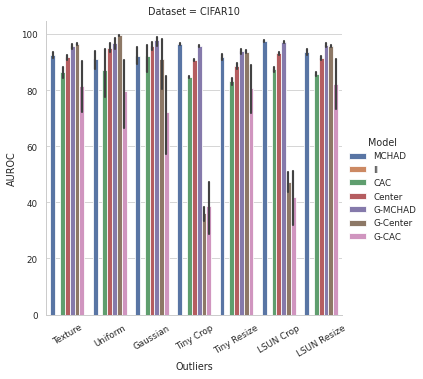

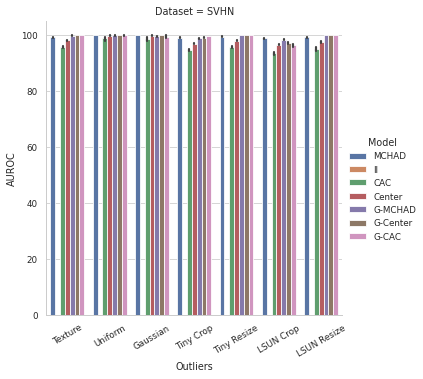

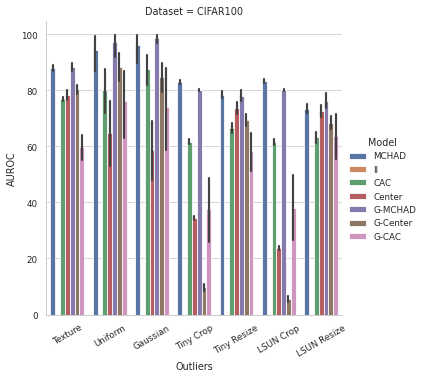

In [53]:
methods = ["MCHAD", "II", "CAC", "Center", "G-MCHAD", "G-Center", "G-CAC"]
# ,
for dataset in ["CIFAR10", "SVHN", "CIFAR100"]:
    g = sb.catplot(
        data=df.reset_index()[df.reset_index()["Dataset"] == dataset],
        x="Outliers",
        y="AUROC",
        kind="bar",
        hue="Model",
        col="Dataset",
        hue_order=methods
    )
    g.set_xticklabels(rotation=30)
    plt.savefig(f"out/single-auroc-{dataset}.png", dpi=300)
    plt.show()

In [54]:
tmp = df.reset_index().copy()
# tmp = tmp[(tmp["Model"] == "MCHAD") | (tmp["Model"] == "G-MCHAD")| (tmp["Model"] == "G-CAC") | (tmp["Model"] == "G-Center")]

print(
    tmp
    .groupby(by=["Dataset", "Model"])
    .agg(
        {
            "Accuracy": ["mean", "sem"],
            "AUROC": ["mean", "sem"],
            "AUPR-IN": ["mean", "sem"],
            "AUPR-OUT": ["mean", "sem"],
            "FPR95": ["mean", "sem"],
        }
    )
    .to_html(
        float_format="%.2f",
        escape=False,
    )
)


<table border="1" class="dataframe">
  <thead>
    <tr>
      <th></th>
      <th></th>
      <th colspan="2" halign="left">Accuracy</th>
      <th colspan="2" halign="left">AUROC</th>
      <th colspan="2" halign="left">AUPR-IN</th>
      <th colspan="2" halign="left">AUPR-OUT</th>
      <th colspan="2" halign="left">FPR95</th>
    </tr>
    <tr>
      <th></th>
      <th></th>
      <th>mean</th>
      <th>sem</th>
      <th>mean</th>
      <th>sem</th>
      <th>mean</th>
      <th>sem</th>
      <th>mean</th>
      <th>sem</th>
      <th>mean</th>
      <th>sem</th>
    </tr>
    <tr>
      <th>Dataset</th>
      <th>Model</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th rowspan="6" valign="top">CIFAR10</th>
      <th>CAC</th>
      <td>94.54</td>
      <td>0.03</td>
      <td>86.73</td>
      <td>0.78</td>
      <td>8

In [55]:
tmp.groupby(by=["Dataset", "Model"]).agg(
    {
        "Accuracy": ["mean", "sem"],
        "AUROC": ["mean", "sem"],
        "AUPR-IN": ["mean", "sem"],
        "AUPR-OUT": ["mean", "sem"],
        "FPR95": ["mean", "sem"],
    }
)

Accuracy                AUROC              AUPR-IN  \
                        mean       sem       mean       sem       mean   
Dataset  Model                                                           
CIFAR10  CAC       94.541430  0.030218  86.733205  0.780218  83.665518   
         Center    94.431429  0.010807  92.450003  0.277450  88.807291   
         G-CAC     67.711429  2.826862  68.155655  2.497073  69.289276   
         G-Center  94.157620  0.012413  80.061062  2.167690  83.808296   
         G-MCHAD   94.687619  0.011642  96.275601  0.231908  93.688264   
         MCHAD     94.816191  0.013864  93.722150  0.406887  89.064862   
CIFAR100 CAC       75.375714  0.055421  71.111859  1.069652  65.577685   
         Center    78.001904  0.018920  58.064128  1.994063  56.780271   
         G-CAC      1.703810  0.045850  58.275887  2.369245  63.274744   
         G-Center  77.221428  0.014184  58.104235  2.769365  60.272405   
         G-MCHAD   77.346666  0.025653  85.602233  0.854683  82.121546   
         MCHAD     77.675715  0.021230  85.239029  0.917127  80.503521   
SVHN     CAC       94.527797  0.030380  95.783266  0.181636  88.389682   
         Center    96.070770  0.008618  97.896502  0.105552  94.082369   
         G-CAC     94.143655  0.026966  99.229688  0.119268  98.035531   
         G-Center  95.883638  0.012265  99.407901  0.094182  98.491049   
         G-MCHAD   95.683701  0.007421  99.320566  0.057935  96.890145   
         MCHAD     95.803882  0.009462  99.248687  0.045787  97.307092   

                              AUPR-OUT                FPR95            
                        sem       mean       sem       mean       sem  
Dataset  Model                                                         
CIFAR10  CAC       0.774683  85.629100  0.774311  52.366939  2.421561  
         Center    0.438228  92.673077  0.367959  29.831224  1.590764  
         G-CAC     2.150212  73.573498  1.933630  52.880680  3.360353  
         G-Center  1.610182  79.184965  2.058012  38.078231  3.429308  
         G-MCHAD   0.450249  97.258647  0.166027  11.617483  0.631885  
         MCHAD     0.773498  95.614311  0.249388  16.428640  0.786052  
CIFAR100 CAC       1.125069  72.776403  1.262033  67.880748  2.516562  
         Center    1.494242  67.495331  1.611323  69.225170  1.933933  
         G-CAC     1.757916  61.631509  1.805399  78.922109  2.881721  
         G-Center  1.701058  66.921143  2.038734  67.229184  2.710492  
         G-MCHAD   1.027218  87.451197  0.805514  42.927959  2.312697  
         MCHAD     1.033035  87.914346  0.771342  40.877143  2.112246  
SVHN     CAC       0.416002  97.546872  0.143386  15.793539  1.101361  
         Center    0.227899  98.864862  0.076918   6.532201  0.316711  
         G-CAC     0.330923  99.519690  0.081927   2.566282  0.456088  
         G-Center  0.243493  99.732238  0.044092   2.319882  0.356969  
         G-MCHAD   0.266096  99.776321  0.020131   2.281415  0.199192  
         MCHAD     0.154549  99.745160  0.016398   3.095013  0.195522

In [56]:
from scipy.stats import ttest_ind

tmp = df.reset_index().copy()
# tmp = tmp[(tmp["Model"] == "MCHAD") | (tmp["Model"] == "G-MCHAD")]

for metric in ["Accuracy", "AUROC", "AUPR-IN", "AUPR-OUT", "FPR95"]:
    for dataset in ["SVHN", "CIFAR10", "CIFAR100"]:
        a = tmp[(tmp["Model"] == "CAC") & (tmp["Dataset"] == dataset)][metric]
        b = tmp[(tmp["Model"] == "MCHAD") & (tmp["Dataset"]== dataset)][metric]
        stat, p = ttest_ind(a,b, equal_var=False)
        print(f"{metric} {dataset} -> {p < 0.05} ")

Accuracy SVHN -> True 
Accuracy CIFAR10 -> True 
Accuracy CIFAR100 -> True 
AUROC SVHN -> True 
AUROC CIFAR10 -> True 
AUROC CIFAR100 -> True 
AUPR-IN SVHN -> True 
AUPR-IN CIFAR10 -> True 
AUPR-IN CIFAR100 -> True 
AUPR-OUT SVHN -> True 
AUPR-OUT CIFAR10 -> True 
AUPR-OUT CIFAR100 -> True 
FPR95 SVHN -> True 
FPR95 CIFAR10 -> True 
FPR95 CIFAR100 -> True 
